In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_means, z_log_vars = inputs
        batch = tf.shape(z_means)[0]
        dim   = tf.shape(z_means)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim,-1))
        return z_means + tf.exp(0.5 * z_log_vars) * epsilon

In [7]:
from keras.models import Model
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import MaxPool2D, UpSampling2D, concatenate, Dropout, Dense, Flatten, UpSampling2D


stride = 1
kernel = 3
pool_size  = (2, 2)
input_size  = 256,256,1
finest_dim = 8
latent_dim = 2

# 1 image : 256,256,1(grayscale)
encoder_inputs = keras.Input(shape=(256,256,1), name='OCTA_image') 

# 1st layer : [(256,256,1)] -> [(128,128,finest_dim=8)]
l1_cv = Conv2D(finest_dim, (kernel, kernel), strides=stride, padding="same")(encoder_inputs)
l1_bn = BatchNormalization()(l1_cv)
l1_ac = Activation("relu")(l1_bn)
l1_pl = MaxPool2D(pool_size)(l1_ac)

# 2nd layer : [(256,256,1)] -> [(128,128,finest_dim=8)]
l2_cv = Conv2D(finest_dim*2,(kernel,kernel), strides=stride, padding="same")(l1_pl)
l2_bn = BatchNormalization()(l2_cv)
l2_ac = Activation("relu")(l2_bn)
l2_pl = MaxPool2D(pool_size)(l2_ac)

# 3rd layer : [(64, 64, finest_dim*2=16)] -> [(32,32,finest_dim*4=32)]
l3_cv = Conv2D(finest_dim*4,(kernel,kernel), strides=stride, padding="same")(l2_pl)
l3_bn = BatchNormalization()(l3_cv)
l3_ac = Activation("relu")(l3_bn)
l3_pl = MaxPool2D(pool_size)(l3_ac)

# 4th layer : [(32, 32, finest_dim*8=32)] -> [(16, 16, finest_dim*16=128)]
l4_cv = Conv2D(finest_dim*8,(kernel,kernel), strides=stride, padding="same")(l3_pl)
l4_bn = BatchNormalization()(l4_cv)
l4_ac = Activation("relu")(l4_bn)
l4_pl = MaxPool2D(pool_size)(l4_ac)

# 5th layer :  [(16, 16, finest_dim*16=128)] -> [(8, 8, finest_dim*16=128=latent_dim)]
l5_cv = Conv2D(finest_dim*16,(kernel,kernel), strides=stride, padding="same")(l4_pl)
l5_bn = BatchNormalization()(l5_cv)
l5_ac = Activation("relu")(l5_bn)
l5_pl = MaxPool2D(pool_size)(l5_ac)

latent_dim = 2
z_mean          = layers.Dense(latent_dim, name="z_mean")(l5_pl)    # 32, 784
z_log_var       = layers.Dense(latent_dim, name="z_log_var")(l5_pl) # 32, 784 
z = Sampling()((z_mean, z_log_var)) # 32, 784, 2

encoder_seg   = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="Seg_encoder")
encoder_seg.summary()


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [1]:
# decoder
decoder_inputs = tf.keras.Input(shape=(2,), name="z_sampling")

# 5th layer : [(16, 16, latent_dim)] -> [(32, 32, latent_dim)]
l5_cv = Conv2D(latent_dim, (kernel,kernel), padding="same")(decoder_inputs)
l5_bn = BatchNormalization()(l5_cv)
l5_ac = Activation("relu")(l5_bn)
l5_up = UpSampling2D(interpolation='bilinear')(l5_ac)

# 4th layer : [(32, 32, latent_dim)] -> [(64, 64, latent_dim)]
# l4_in = concatenate([l5_up, l4_pl], axis=-1)
l4_cv = Conv2D(finest_dim*8, (kernel,kernel), padding="same")(l5_up)
l4_bn = BatchNormalization()(l4_cv)
l4_ac = Activation("relu")(l4_bn)
l4_up = UpSampling2D(interpolation='bilinear')(l4_ac)

# 3rd layer
# l3_in = concatenate([l4_up, l3_pl], axis=-1)
l3_cv = Conv2D(finest_dim*4, (kernel,kernel), padding="same")(l4_up)
l3_bn = BatchNormalization()(l3_cv)
l3_ac = Activation("relu")(l3_bn)
l3_up = UpSampling2D(interpolation='bilinear')(l3_ac)

# 2nd layer
# l2_in = concatenate([l3_up, l2_pl], axis=-1)
l2_cv = Conv2D(finest_dim*2, (kernel,kernel), padding="same")(l3_up)
l2_bn = BatchNormalization()(l2_cv)
l2_ac = Activation("relu")(l2_bn)
l2_up = UpSampling2D(interpolation='bilinear')(l2_ac)

# 1st layer
# l1_in = concatenate([l2_up, l1_pl], axis=-1)
l1_cv = Conv2D(latent_dim  , (kernel,kernel), padding="same")(l2_up)
l1_bn = BatchNormalization()(l1_cv)
l1_ac = Activation("relu")(l1_bn)
l1_up = UpSampling2D(interpolation='bilinear')(l1_ac)

decoder_out = Conv2D(1,(kernel,kernel),padding="same")(l1_up)
decoder_out = BatchNormalization()(decoder_out)
decoder_out = Activation("sigmoid")(decoder_out)

decoder_seg = keras.Model(decoder_inputs, decoder_out, name="SegNet_decoder")
decoder_seg.summary()


NameError: name 'tf' is not defined

In [5]:
# KL 발산 규제 손실을 추가합니다.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
encoder_seg.add_loss(kl_loss)

In [6]:
import os
import cv2

CROPDIR = '/Share/data/crop'
files = os.listdir(CROPDIR)

datas = []
for idx, f in enumerate(files):
    datas.append(cv2.imread(os.path.join(CROPDIR,f), cv2.IMREAD_GRAYSCALE))

datas = np.expand_dims(datas, -1).astype("float32") / 255 # 이 한 줄로 65,256,256 -> 65,256,256,1 + normalizing 까지 ...
datas = tf.cast(datas,tf.float32)
print(datas.shape)


(65, 256, 256, 1)


In [7]:
# # 손실과 옵티마이저
# loss_fn   = tf.keras.losses.MeanSquaredError()
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# # 훈련을 위해 모델을 설정합니다.
# encoder_seg.compile(optimizer, loss=loss_fn)

# # 모델을 훈련합니다.
# decoder_seg.fit(dataset, epochs=1)

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            data = tf.reshape(data,(65,256,256,1))
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction       = self.decoder(z)
            # data=tf.expand_dims(data, axis=0).shape.as_list()
            print('data shape:', np.shape(data))
            print('recon shape:',np.shape(reconstruction))

            reconstruction_loss  = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    # keras.losses.MeanSquaredError(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
vae = VAE(encoder_seg, decoder_seg)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(datas, epochs=1000, batch_size=4)

Epoch 1/1000


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-8-216397c369a8>:23 train_step  *
        z_mean, z_log_var, z = self.encoder(data)
    <ipython-input-2-09d3d714c111>:9 call  *
        return z_means + tf.exp(0.5 * z_log_vars) * epsilon
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:1283 _mul_dispatch
        return gen_math_ops.mul(x, y, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_math_ops.py:6092 mul
        "Mul", x=x, y=y, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 8 and 65 for '{{node Seg_encoder/sampling/mul_1}} = Mul[T=DT_FLOAT](Seg_encoder/sampling/Exp, Seg_encoder/sampling/random_normal)' with input shapes: [65,8,8,128], [65,8,?].


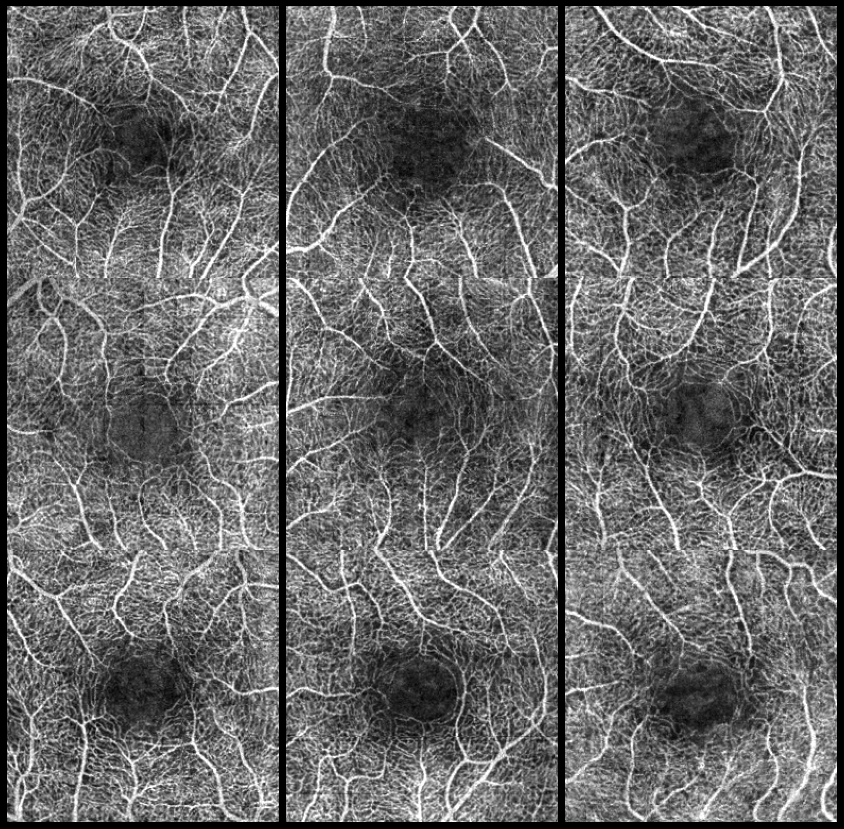

ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer conv2d_16 is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: [None, 2]


In [36]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 256
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.show()

plt.figure(figsize=(15, 15))
for idx in range(1,10):
    plt.subplot(3,3,idx), plt.imshow(np.reshape(datas[idx], (256,256)), cmap='gray'), plt.axis(False)
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

plot_latent_space(vae, n=3)

In [22]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, z = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.imshow(z_mean.reshape(ROW,COL), cmap='gray')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_label_clusters(vae, datas, datas)

ValueError: cannot reshape array of size 130 into shape (256,256)